### Import required packages

In [16]:
import jax.numpy as jnp
from jax import random
import numpyro
import pandas as pd
import numpy as np
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az


'''print("NumPy:", jn.__version__) # should be 1.26.4
print("SciPy:", scipy.__version__) # should be1.10.1
print("PyTensor:", pytensor.__version__) # should be2.20.0
print("PyMC:", pm.__version__) # should be5.13.1'''

'print("NumPy:", jn.__version__) # should be 1.26.4\nprint("SciPy:", scipy.__version__) # should be1.10.1\nprint("PyTensor:", pytensor.__version__) # should be2.20.0\nprint("PyMC:", pm.__version__) # should be5.13.1'

### Read in data

In [17]:
df_FinBERT = pd.read_csv('../data/sp500_headlines_2008_2024_FinBERT.csv')
df_FinBERT['Date'] = pd.to_datetime(df_FinBERT['Date'])
df_FinBERT = df_FinBERT.sort_values('Date').reset_index(drop=True)

### Data pre-processing

In [18]:
# Build daily table for the outcome (one row per day)
daily = (df_FinBERT.groupby("Date", as_index=False)
           .agg(Return=("Return", "last")))
daily["t_idx"] = np.arange(len(daily))

# Map each headline to its day's index
date_to_idx = dict(zip(daily["Date"], daily["t_idx"]))
df_FinBERT["t_idx"] = df_FinBERT["Date"].map(date_to_idx)

# Subset of all non-NA FinBERT sentiments
obs_fin = df_FinBERT.loc[~df_FinBERT["finbert_sent"].isna(), ["t_idx", "finbert_sent"]]
t_fin = obs_fin["t_idx"].to_numpy(dtype=int)
s_fin = obs_fin["finbert_sent"].to_numpy(dtype=float)

# Outcome vector (daily returns) and T (#days)
y = daily["Return"].to_numpy(dtype=float)
T = len(daily)

# Also handy: C_t = number of headlines per day (not required, but can be used for heteroskedastic measurement noise)
C_per_day = df_FinBERT.groupby("t_idx").size().reindex(range(T)).fillna(0).to_numpy(int)

# For each observed headline get the day's C_t (useful if modeling sigma ∝ 1/sqrt(C_t))
C_fin = C_per_day[t_fin]

# cast for jax
T_py = int(T)
y_jnp     = jnp.array(y)
t_fin_jnp = jnp.array(t_fin, dtype=jnp.int32)
s_fin_jnp = jnp.array(s_fin)
C_fin_jnp = jnp.array(C_fin)


### Sampling algorithms for different priors

In [19]:
# iid-prior for theta
def model_iid(T, y, t_fin, s_fin, C_fin):
    # Latente Tages-Sentiments (i.i.d.)
    sigma_theta = numpyro.sample("sigma_theta", dist.HalfNormal(1.0))
    theta = numpyro.sample("theta", dist.Normal(0.0, sigma_theta).expand([T]).to_event(1))

    # Messfehler-Varianz skaliert mit 1/sqrt(C_t)
    sigma_fin_base = numpyro.sample("sigma_fin_base", dist.HalfNormal(0.5))
    sigma_fin = sigma_fin_base / jnp.sqrt(jnp.clip(C_fin, 1.0, 1e9))

    # Headlines-Likelihood (je Headline Beobachtung)
    mu_fin = theta[t_fin]
    numpyro.sample("finbert_obs", dist.Normal(mu_fin, sigma_fin), obs=s_fin)

    # Downstream: Returns ~ theta
    gamma0 = numpyro.sample("gamma0", dist.Normal(0.0, 0.01))
    gamma1 = numpyro.sample("gamma1", dist.Normal(0.0, 0.01))
    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(0.01))

    mu_y = gamma0 + gamma1 * theta
    numpyro.sample("y_obs", dist.Normal(mu_y, sigma_y), obs=y)

# AR(1)-prior for theta 
def model_ar1(T, y, t_fin, s_fin, C_fin):
    # AR(1)-Parameter
    rho = numpyro.sample("rho", dist.Uniform(-0.95, 0.95))
    tau = numpyro.sample("tau", dist.HalfNormal(1.0))
    mu_theta = numpyro.sample("mu_theta", dist.Normal(0.0, 1.0))

    # Stationäre Varianz der AR(1)
    sigma0 = tau / jnp.sqrt(1.0 - rho**2 + 1e-8)

    # AR(1) State-Space
    theta0 = numpyro.sample("theta_0", dist.Normal(mu_theta, sigma0))
    thetas = [theta0]
    for t in range(1, int(T)):
        mean_t = mu_theta * (1.0 - rho) + rho * thetas[-1]
        thetas.append(numpyro.sample(f"theta_{t}", dist.Normal(mean_t, tau)))
    theta = jnp.stack(thetas)  # shape (T,)

    # Messfehler-Varianz: 1/sqrt(C_t)
    sigma_fin_base = numpyro.sample("sigma_fin_base", dist.HalfNormal(0.5))
    sigma_fin = sigma_fin_base / jnp.sqrt(jnp.clip(C_fin, 1.0, 1e9))

    # Headlines-Likelihood
    mu_fin = theta[t_fin]
    numpyro.sample("finbert_obs", dist.Normal(mu_fin, sigma_fin), obs=s_fin)

    # Downstream: Returns ~ theta
    gamma0 = numpyro.sample("gamma0", dist.Normal(0.0, 0.01))
    gamma1 = numpyro.sample("gamma1", dist.Normal(0.0, 0.01))
    sigma_y = numpyro.sample("sigma_y", dist.HalfNormal(0.01))

    mu_y = gamma0 + gamma1 * theta
    numpyro.sample("y_obs", dist.Normal(mu_y, sigma_y), obs=y)



### iid-posterior

C:\Users\49176\AppData\Local\Temp\ipykernel_2720\977082234.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=800, num_samples=1200, num_chains=2, progress_bar=True)
sample: 100%|██████████| 2000/2000 [10:01<00:00,  3.32it/s, 511 steps of size 9.31e-03. acc. prob=0.95]


                  mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
gamma0          0.0032  0.0001  0.0031   0.0034     0.0000   0.0000   
gamma1          0.0121  0.0003  0.0116   0.0127     0.0000   0.0000   
sigma_y         0.0020  0.0001  0.0018   0.0023     0.0000   0.0000   
sigma_theta     0.6678  0.0191  0.6345   0.7043     0.0016   0.0007   
sigma_fin_base  2.4667  0.0130  2.4397   2.4893     0.0002   0.0003   

                 ess_bulk   ess_tail   r_hat  
gamma0           508.4830  1001.9505  1.0031  
gamma1           134.2164   265.7242  1.0178  
sigma_y           91.1527   234.2273  1.0526  
sigma_theta      151.6040   379.6563  1.0181  
sigma_fin_base  3842.7914  1640.2045  1.0008  


<Axes: title={'center': 'gamma1'}>

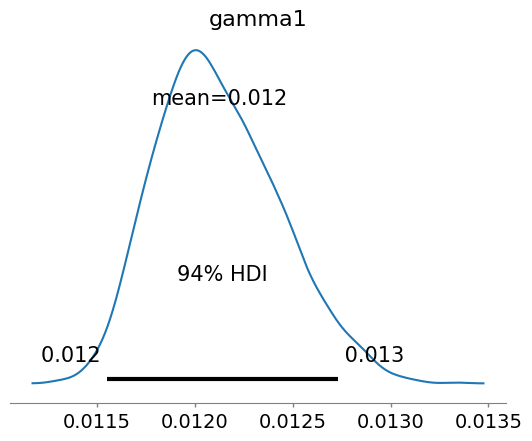

In [20]:
rng_key = random.PRNGKey(42)

# i.i.d.-theta (schneller erster Lauf)
nuts = NUTS(model_iid, target_accept_prob=0.9)
mcmc = MCMC(nuts, num_warmup=800, num_samples=1200, num_chains=2, progress_bar=True)
mcmc.run(rng_key, T=T_py, y=y_jnp, t_fin=t_fin_jnp, s_fin=s_fin_jnp, C_fin=C_fin_jnp)
posterior_iid = mcmc.get_samples()
idata_iid = az.from_numpyro(mcmc)

print(az.summary(idata_iid, var_names=["gamma0","gamma1","sigma_y","sigma_theta","sigma_fin_base"], round_to=4))
az.plot_posterior(idata_iid, var_names=["gamma1"])


### AR(1)-posterior

In [ ]:
rng_key = random.PRNGKey(123)

nuts_ar1 = NUTS(model_ar1, target_accept_prob=0.9)
mcmc_ar1 = MCMC(nuts_ar1, num_warmup=1000, num_samples=1500, num_chains=2, progress_bar=True)
mcmc_ar1.run(rng_key, T=T_py, y=y_jnp, t_fin=t_fin_jnp, s_fin=s_fin_jnp, C_fin=C_fin_jnp)
idata_ar1 = az.from_numpyro(mcmc_ar1)

print(az.summary(idata_ar1, var_names=["gamma0","gamma1","sigma_y","mu_theta","rho","tau","sigma_fin_base"], round_to=4))
az.plot_posterior(idata_ar1, var_names=["gamma1","rho"])

In [ ]:
# Posterior-Mittel von theta bei AR(1):
theta_names = [v for v in idata_ar1.posterior.data_vars if v.startswith("theta_")] + (["theta_0"] if "theta_0" in idata_ar1.posterior.data_vars else [])
# Sortieren nach Index
theta_names = sorted(theta_names, key=lambda s: int(s.split("_")[1]) if "_" in s else 0)

theta_stack = jnp.stack([idata_ar1.posterior[v].values for v in theta_names], axis=0)  # (T, chains, draws)
theta_mean = theta_stack.mean(axis=(1,2))  # (T,)

# In dein daily mergen
daily_plot = daily.copy()
daily_plot["theta_mean"] = np.array(theta_mean)
print(daily_plot.head())


### Export results

iid-prior

In [23]:
summary_df = az.summary(
    idata_iid,
    var_names=["gamma0", "gamma1", "sigma_y", "sigma_theta", "sigma_fin_base"],
    round_to=6
)
summary_df.to_csv("../data/iid_summary.csv")

th = idata_iid.posterior["theta"]  # (chain, draw, time)
theta_mean = th.mean(dim=("chain","draw")).to_numpy()
theta_lo   = th.quantile(0.025, dim=("chain","draw")).to_numpy()
theta_hi   = th.quantile(0.975, dim=("chain","draw")).to_numpy()
daily_iid = daily.copy()
daily_iid["theta_mean"] = theta_mean
daily_iid["theta_low"]  = theta_lo
daily_iid["theta_high"] = theta_hi
daily_iid.to_csv("../data/latent_sentiment_iid.csv", index=False)


AR(1)-prior

In [ ]:
summary_ar1 = az.summary(
    idata_ar1,
    var_names=["gamma0","gamma1","sigma_y","mu_theta","rho","tau","sigma_fin_base"],
    round_to=6
)
summary_ar1.to_csv("../data/ar1_summary.csv")


theta_vars = [v for v in idata_ar1.posterior.data_vars if re.fullmatch(r"theta_\d+", v)]
theta_vars = sorted(theta_vars, key=lambda s: int(s.split("_")[1]))  # numerisch sortieren
theta_stack = np.stack([idata_ar1.posterior[v].values for v in theta_vars], axis=0)
theta_mean = theta_stack.mean(axis=(1,2))
theta_low  = np.quantile(theta_stack, 0.025, axis=(1,2))
theta_high = np.quantile(theta_stack, 0.975, axis=(1,2))
daily_ar1 = daily.copy()  # enthält Date in der richtigen Reihenfolge / t_idx
daily_ar1["theta_mean"] = theta_mean
daily_ar1["theta_low"]  = theta_low
daily_ar1["theta_high"] = theta_high
daily_ar1.to_csv("../data/latent_sentiment_ar1.csv", index=False)